# Universidade de Brasília - UnB
## Programa de Pós-Graduação em Computação Aplicada - PPCA

Disciplina: **Análise Estatístia de Dados e Informações - AEDI**  
Professor: **João Gabriel de Moraes Souza**  
Aluno: **Felipe Schiavon de Oliveira** (matrícula: 20/0077104)

# Tarefa 3 - Criar e analisar uma carteira de investimento e encontrar a Fronteira Eficiente de Markowitz

### Importando pacotes

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_datareader.data as web
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

### Fazendo o download dos dados da ação PFE (Pfizer Inc.) para verificar as variáveis e a estrutura dos dados

In [2]:
pfe_df = web.DataReader('PFE', 'yahoo', start="2010-01-01", end="2021-08-29")
pfe_df

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2010-01-04  17.969639  17.305504  17.333965  17.960152  54898644.0  11.590302
2010-01-05  17.960152  17.599621  17.950665  17.703985  45714931.0  11.424991
2010-01-06  17.846300  17.561670  17.703985  17.647058  43640975.0  11.388254
2010-01-07  17.713472  17.514231  17.685009  17.580645  41557112.0  11.345395
2010-01-08  17.751423  17.571157  17.666035  17.722960  32049716.0  11.437235
...               ...        ...        ...        ...         ...        ...
2021-08-23  51.360001  49.599998  50.290001  49.930000  88652400.0  49.930000
2021-08-24  50.049999  48.240002  49.740002  48.380001  52624100.0  48.380001
2021-08-25  48.279999  46.930000  48.040001  47.509998  51036800.0  47.509998
2021-08-26  48.160000  47.299999  47.700001  47.380001  29029300.0  47.380001
2021-08-27  47.500000  46.529999  47.369999  46.599998  32874400.0  46.599998

[2934 rows x 6 columns]

## Criando uma base de dados com quatro ações e um indicador de mercado

Optou-se por selecionar ações de grandes farmacêuticas envolvidas no processo de produção de vacinas contra o Covid-19: Pfizer (PFE), Moderna (MRNA), Johnson & Johnson (JNJ) e AstraZeneca (AZN). Utilizou-se, também, o Índice Nasdaq Composite (^IXIC), para fins de comparação. 

In [3]:
# Criando uma lista de ações: Pfizer, Moderna, Johnson & Johnson, AstraZeneca.
acoes = ['PFE', 'MRNA', 'JNJ', 'AZN', '^IXIC']

In [4]:
# Criando um DataFrame com o valor de fechamento das ações
acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = web.DataReader(acao, 'yahoo', start="2018-12-07", end="2021-08-29")['Close']
acoes_df.to_csv('acoes_df.csv')

Considerando que só há dados disponíveis da Moderna a partir de 07/12/2018, definiu-se essa data como o início para a coleta de dados e utilizou-se os dados da variável Close, que corresponde ao valor da ação no fechamento.

In [5]:
# Verificando primeiros registros do DataFrame
acoes_df.head()

PFE       MRNA         JNJ        AZN        ^IXIC
Date                                                                
2018-12-07  41.669830  18.600000  145.429993  38.180000  6969.250000
2018-12-10  42.125237  18.799999  145.259995  38.410000  7020.520020
2018-12-11  41.755219  18.010000  146.500000  38.660000  7031.830078
2018-12-12  41.897533  18.680000  147.100006  38.910000  7098.310059
2018-12-13  42.286530  18.760000  147.839996  39.240002  7070.330078

In [6]:
# Transformando o índice (que está como data) em uma variável do DataFrame
acoes_df = acoes_df.reset_index()
acoes_df

Date        PFE        MRNA         JNJ        AZN         ^IXIC
0   2018-12-07  41.669830   18.600000  145.429993  38.180000   6969.250000
1   2018-12-10  42.125237   18.799999  145.259995  38.410000   7020.520020
2   2018-12-11  41.755219   18.010000  146.500000  38.660000   7031.830078
3   2018-12-12  41.897533   18.680000  147.100006  38.910000   7098.310059
4   2018-12-13  42.286530   18.760000  147.839996  39.240002   7070.330078
..         ...        ...         ...         ...        ...           ...
681 2021-08-23  49.930000  411.890015  177.610001  58.799999  14942.650391
682 2021-08-24  48.380001  394.940002  175.389999  58.520000  15019.799805
683 2021-08-25  47.509998  397.869995  174.229996  58.580002  15041.860352
684 2021-08-26  47.380001  400.299988  173.300003  58.759998  14945.809570
685 2021-08-27  46.599998  382.220001  172.929993  58.630001  15129.500000

[686 rows x 6 columns]

## Visualizando os dados - preço

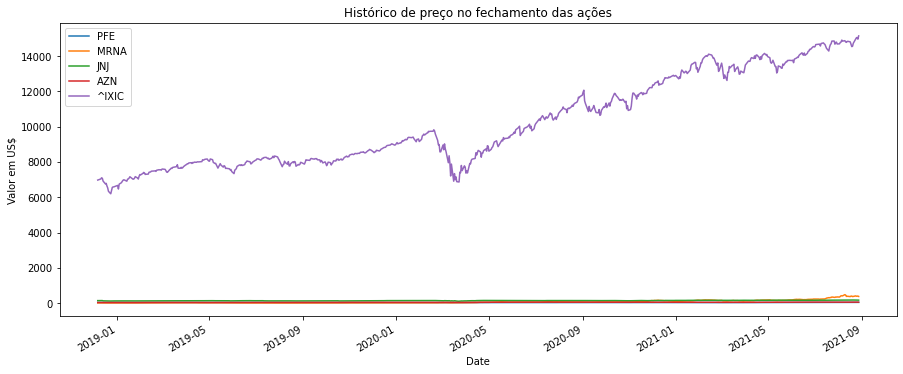

In [7]:
# Plotando o gráfico dos ativos ao longo do tempo
acoes_df.plot(x = "Date", figsize=(15, 6), ylabel="Valor em US$", title="Histórico de preço no fechamento das ações");

Verifica-se que os preços do índice ^IXIC representam valores bem superior ao dos demais ativos selecionados na carteira. Também é possível observar que há uma variação superior no preço das ações da MRNA entre o mês de maio e o mês de setembro de 2021.

## Taxa de variação geral dos preços (normalizado)

Vamos analisar, agora, a variação do preço de cada um dos ativos, definindo o preço de referência como a primeira observação do nosso conjunto de dados.

In [8]:
# Iteramos as colunas dos ativos para calcular a variação de preços.
acoes_df_variacao = acoes_df.copy()
for i in acoes_df_variacao.columns[1:]:
    acoes_df_variacao[i] = acoes_df_variacao[i] / acoes_df_variacao[i][0]
acoes_df_variacao.to_csv('acoes_df_variacao.csv')
acoes_df_variacao

Date       PFE       MRNA       JNJ       AZN     ^IXIC
0   2018-12-07  1.000000   1.000000  1.000000  1.000000  1.000000
1   2018-12-10  1.010929   1.010753  0.998831  1.006024  1.007357
2   2018-12-11  1.002049   0.968280  1.007358  1.012572  1.008979
3   2018-12-12  1.005464   1.004301  1.011483  1.019120  1.018519
4   2018-12-13  1.014800   1.008602  1.016572  1.027763  1.014504
..         ...       ...        ...       ...       ...       ...
681 2021-08-23  1.198229  22.144624  1.221275  1.540073  2.144083
682 2021-08-24  1.161032  21.233333  1.206010  1.532740  2.155153
683 2021-08-25  1.140153  21.390860  1.198033  1.534311  2.158318
684 2021-08-26  1.137034  21.521504  1.191639  1.539026  2.144536
685 2021-08-27  1.118315  20.549462  1.189094  1.535621  2.170894

[686 rows x 6 columns]

Vamos plotar o gráfico com o histórico novamente, mas dessa vez da variação de preço dos ativos.

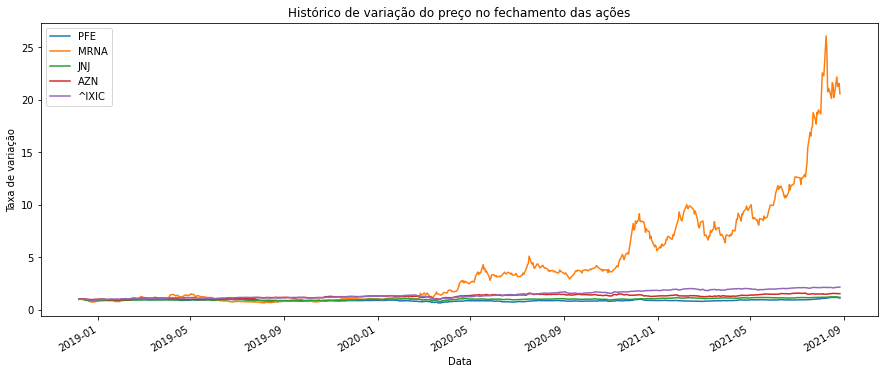

In [9]:
# Plotando o gráfico de variação de preço dos ativos ao longo do tempo
acoes_df_variacao.plot(x = "Date", figsize=(15, 6), ylabel="Taxa de variação",
                       title="Histórico de variação do preço no fechamento das ações",
                       xlabel="Data");

Observa-se que entre o mês de janeiro e o mês de maio de 2020 a taxa de variação do valor das ações da MRNA iniciou um crescimento que continua evoluindo até o dia de hoje. Apesar do fim do período constatar-se uma queda, é possível que a taxa de variação continue em crescimento, conforme observa-se em meses anteriores em que houve quedas após os picos, mas retomada do crescimento posteriormente.

Esse crescimento, provavelmente, está relacionado ao papel da farmacêutica Moderna na produção da vacina contra o Covid-19, considerando que a vacina da Moderna levou apenas 48 horas para ser desenhada, após a publicação do genoma do vírus.

## Taxa de retorno simples de cada ativo

A taxa de retorno simples mede a valorização de um determinado investimento e representam o ganho ou perda durante uma janela temporal específica.

Calcula-se a taxa de retorno subtraindo o último valor do período pelo primeiro e dividindo esse resultado novamente pelo primeiro. Caso se queira calcular o valor em percentual, multiplica-se por 100.

$$ \mathbb{E}(R) = \mathbb{E}\frac{P_t - P_0}{P_0} $$

In [10]:
# Criação de array com cálculo da taxa de retorno de cada ativo
taxa_retorno_simples = np.array([["PFE", round((((acoes_df["PFE"][len(acoes_df) -1] - acoes_df["PFE"][0]) / acoes_df["PFE"][0])*100), 2)],
                              ["MRNA", round((((acoes_df["MRNA"][len(acoes_df) -1] - acoes_df["MRNA"][0]) / acoes_df["MRNA"][0])*100), 2)],
                              ["JNJ", round((((acoes_df["JNJ"][len(acoes_df) -1] - acoes_df["JNJ"][0]) / acoes_df["JNJ"][0])*100), 2)],
                              ["AZN", round((((acoes_df["AZN"][len(acoes_df) -1] - acoes_df["AZN"][0]) / acoes_df["AZN"][0])*100), 2)],
                              ["^IXIC", round((((acoes_df["^IXIC"][len(acoes_df) -1] - acoes_df["^IXIC"][0]) / acoes_df["^IXIC"][0])*100), 2)]])
taxa_retorno_simples

array([['PFE', '11.83'],
       ['MRNA', '1954.95'],
       ['JNJ', '18.91'],
       ['AZN', '53.56'],
       ['^IXIC', '117.09']], dtype='<U7')

In [11]:
# Colocando a taxa de retorno de cada ativo em um dataframe
taxa_retorno_simples = pd.DataFrame(taxa_retorno_simples, columns=["Ativo", "Taxa de Retorno Simples"])
taxa_retorno_simples.set_index("Ativo", inplace=True)
taxa_retorno_simples

Taxa de Retorno Simples
Ativo                        
PFE                     11.83
MRNA                  1954.95
JNJ                     18.91
AZN                     53.56
^IXIC                  117.09

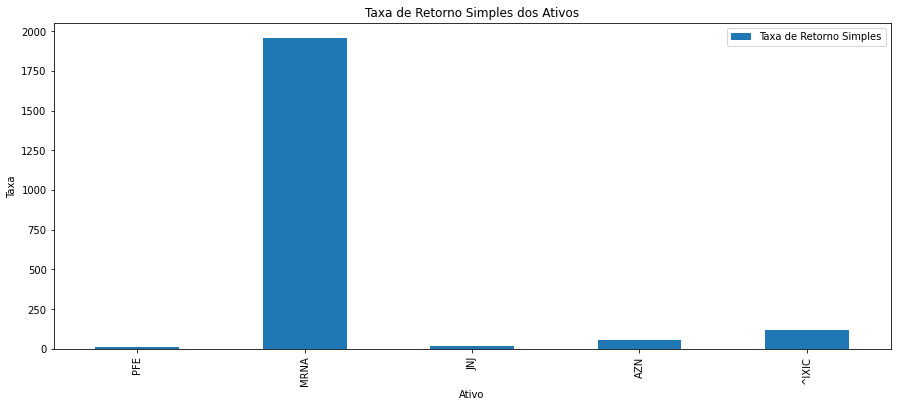

In [12]:
taxa_retorno_simples["Taxa de Retorno Simples"]=taxa_retorno_simples["Taxa de Retorno Simples"].astype(float)
taxa_retorno_simples.plot.bar(title="Taxa de Retorno Simples dos Ativos", ylabel="Taxa", figsize=(15, 6));

A taxa de retorno simples da MRNA foi bastante superior à taxa dos demais ativos. Entretando, tal métrica não pode ser avaliada isoladamente, tendo em vista que, para seu cálculo, considera-se apenas dois valores: o primeiro e o último valor da série. Desa forma, todos os valores diários de fechamento são descartados, não sendo possível verificar, por exemplo, como esse taxa variou ao longo do tempo.

Vamos avaliar, portanto, outras medidas usando estatísticas descritivas para conhecer melhor o comportamento dos ativos.

## Estatísticas descritivas

### Resumo das estatísticas descritivas de preços dos ativos

In [13]:
acoes_df_sdata = acoes_df.drop('Date', 1)
acoes_df_variacao_sdata = acoes_df_variacao.drop('Date', 1)

In [14]:
# Verificando um sumário com as estatísticas descritivas de preço dos ativos
acoes_df_sdata.describe()

PFE        MRNA         JNJ         AZN         ^IXIC
count  686.000000  686.000000  686.000000  686.000000    686.000000
mean    37.123544   79.789592  146.366560   48.547784  10175.227708
std      3.416985   88.308784   13.311829    6.603930   2529.065043
min     27.030361   12.260000  111.139999   35.490002   6192.919922
25%     34.721215   18.707500  136.237499   42.957500   7996.575073
50%     36.548244   46.609999  145.250000   49.690001   9274.544922
75%     39.712998  125.107500  153.950005   53.897501  12736.459961
max     50.419998  484.470001  179.470001   61.099998  15129.500000

In [15]:
acoes_df_sdata["MRNA"].max()

484.4700012207031

### Média dos ativos - Preço e Taxa de Variação

A média é definida como o valor que demonstra a concentração dos dados de uma distribuição, como o ponto de equilíbrio das frequências em um histograma.

$$ {\displaystyle {\frac {1}{n}}\sum _{i=1}^{n}a_{i}={\frac {a_{1}+a_{2}+\cdots +a_{n}}{n}}} $$

In [16]:
# Descobrindo a média de preços de cada ativo financeiro
media = acoes_df_sdata.mean().round(2)
media

PFE         37.12
MRNA        79.79
JNJ        146.37
AZN         48.55
^IXIC    10175.23
dtype: float64

In [17]:
# Descobrindo a média da taxa de variação geral de preços de cada ativo financeiro
media_variacao = acoes_df_variacao_sdata.mean().round(2)
media_variacao

PFE      0.89
MRNA     4.29
JNJ      1.01
AZN      1.27
^IXIC    1.46
dtype: float64

É interessante notar que, embora a média dos preços do índice ^IXIC e do ativo JNJ sejam superiores aos demais, quando analisamos a média da taxa de variação de preços nota-se que o ativo MRNA é quase três superior ao índice ^IXIC e mais do que quatro vezes superior ao ativo JNJ.

Isso ocorre pois a taxa de variação independe do valor absoluto dos ativos. Ela corresponde à variação, ou seja, corresponde a um valor calculado com base na relação entre dois valores.

### Variância dos ativos - Preço e Taxa de Variação

A variância é uma medida de dispersão estatística que indica "o quão longe", em geral, os valores da amostra se encontram do valor esperado. É uma medida adimensional, pois para o cálculo da variância os números são elevados ao quadrado.

Calcula-se a variância somando o quadrado da diferença entre cada valor e o valor esperado (média) e dividindo o resultado pelo tamanho da amostra menos 1.

$$ \sigma^2 = \frac{\sum_{i=1}^{n}(x_i - \mu)^2} {n - 1} $$

In [18]:
# Descobrindo a variância de preços de cada ativo financeiro
variancia = acoes_df_sdata.var().round(2)
variancia

PFE           11.68
MRNA        7798.44
JNJ          177.20
AZN           43.61
^IXIC    6396169.99
dtype: float64

In [19]:
# Descobrindo a variância da taxa de variação geral de preços de cada ativo financeiro
variancia_variacao = acoes_df_variacao_sdata.var().round(decimals=2)
variancia_variacao

PFE       0.01
MRNA     22.54
JNJ       0.01
AZN       0.03
^IXIC     0.13
dtype: float64

### Desvio padrão dos ativos - Preço e Taxa de Variação

O desvio padrão do preço dos ativos é calculado realizando a raiz quadrada da variância. Dessa forma, o desvio-padrão corresponde, também, a uma medida de dispersão estatística, mas diferentemente da variância, é uma medida dimensional.

Dessa forma, para efeitos práticos e de comparação, usa-se o desvio padrão.

$$ \sigma = \sqrt{\frac{\sum_{i=1}^{n}(x_i - \mu)^2} {n - 1}} $$

In [20]:
# Descobrindo o desvio-padrão de preços de cada ativo financeiro
desvio_padrao = acoes_df_sdata.std().round(2)
desvio_padrao

PFE         3.42
MRNA       88.31
JNJ        13.31
AZN         6.60
^IXIC    2529.07
dtype: float64

In [21]:
# Descobrindo o desvio-padrão da taxa de variação geral de preços de cada ativo financeiro
desvio_padrao_variacao = acoes_df_variacao_sdata.std().round(2)
desvio_padrao_variacao

PFE      0.08
MRNA     4.75
JNJ      0.09
AZN      0.17
^IXIC    0.36
dtype: float64

O mesmo comportamento dos dados é percebido quando analisa-se a variância e o desvio padrão de preços versus taxas de variação dos preços. Enquanto no cálculo das duas medidas usando o preço temos como resultado um valor absoluto, o cálculo usando as taxas de variação apresentam resultados relativos.

Nota-se, assim, que o ativo MRNA possui a maior média, a maior variância e o maior desvio padrão no período avaliado.

É interessante notar, também, que nem sempre a maior taxa de variação do preço é melhor, pois a avaliação do desvio padrão é relevante para a decisão da escolha do melhor ativo. Por exemplo, o ativo PFE tem média de taxa de variação de 0.89, enquanto o para o ativo AZN corresponde à 1.27.

Entretanto, o desvio padrão do ativo PFE é 0.08 enquanto do ativo AZN é 0.17. Assim, a dispersão do ativo AZN indica que há um risco maior nesse ativo, tendo em vista que ele varia mais à média do que o ativo PFE. Essa informação é relevante para a tomada de decisão de investimento.

## Gráficos com Função Densidade de Probabilidade do preço dos ativos

Vamos avaliar a distribuição dos preços plotando um gráfico de cada ativo contendo o histograma, a curva de densidade e a indicação da média com um desvio padrão acima e abaixo da média. Assim, além de avaliarmos o formato da distribuição, conseguimos ainda observar duas medidas importantes para a análise dados: a média e o desvio padrão.

A média corresponde à linha vertical pontilhada e o desvio padrão inferior e superior possuem área mais escura abaixo da curva de densidade de probabilidade.

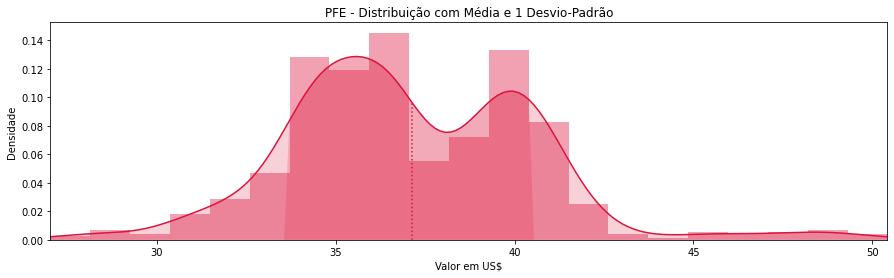

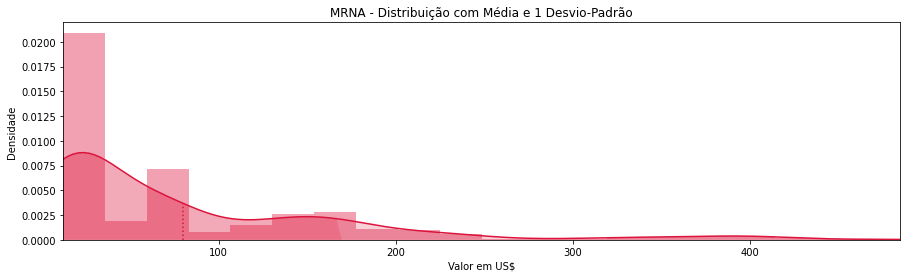

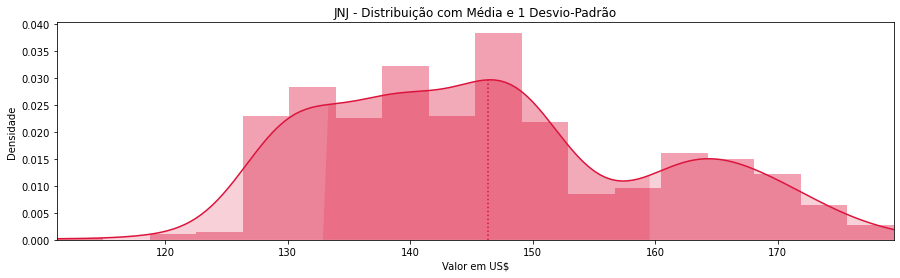

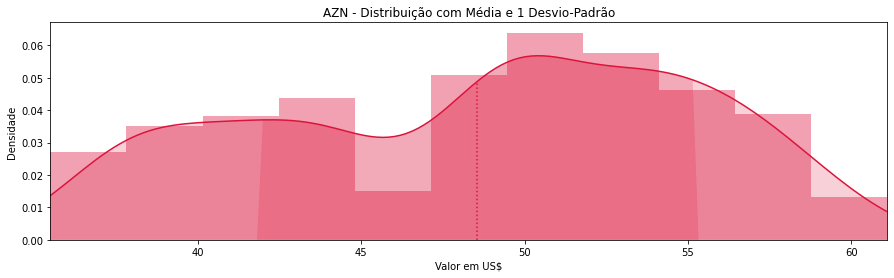

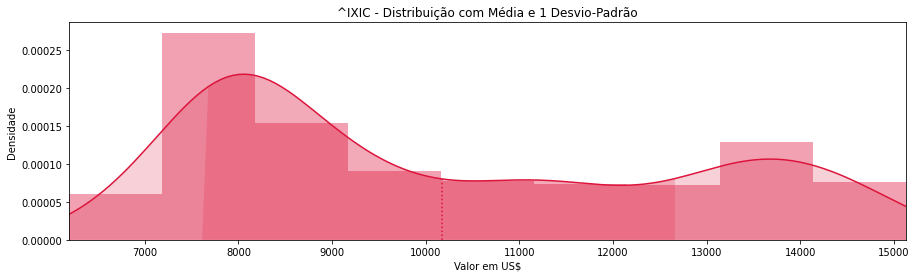

In [22]:
# Criando gráfico com o histograma, curva de densidade, média e 1 desvio-padRão dos ativos

for ativo in acoes:
    plt.figure(figsize=(15,4))
    ax = sns.distplot(acoes_df[ativo], color='crimson', hist=True, kde=True)
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    middle = acoes_df[ativo].mean()
    sdev = acoes_df[ativo].std()
    left = middle - sdev
    right = middle + sdev
    ax.set(xlabel='Valor em US$', ylabel='Densidade', title='%s - Distribuição com Média e 1 Desvio-Padrão' %ativo)
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
    plt.xlim(acoes_df_sdata[ativo].min(), acoes_df_sdata[ativo].max())
    plt.show()

Realizando uma análise visual, considerando o formato das distribuições dos ativos, percebe-se que nenhuma delas assemelha-se à curva de distribuição normal,  também chamada de distribuição Gaussiana, que possui uma curva em forma de sino.

Será realizada, posteriormente, uma teste estatístico para verificarmos se as distribuições correspondem ou não à distribuição normal.

## Gráficos com série histórica da taxa de variação geral dos ativos

Nos gráficos a seguir, apresentamos a série histórica da taxa de variação do preço dos ativos, com a indicação da média (linha vermelha) e um desvio padrão superior e inferior (linhas pontilhadas verdes).  

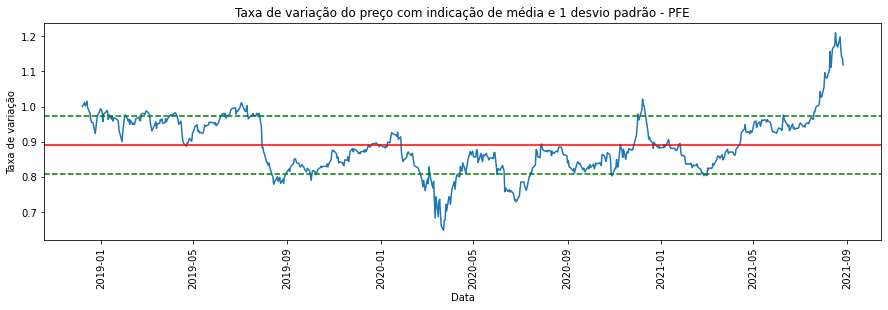

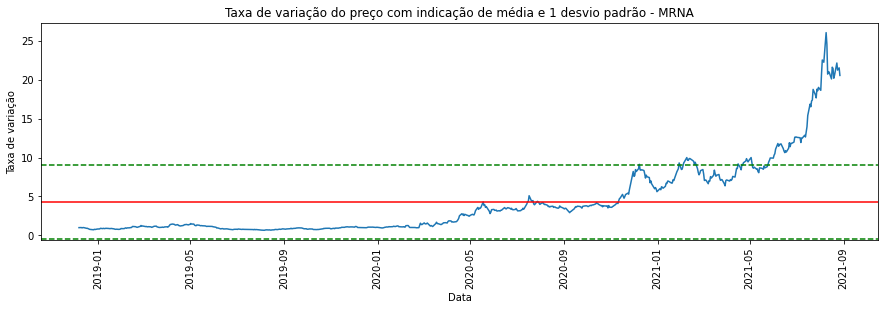

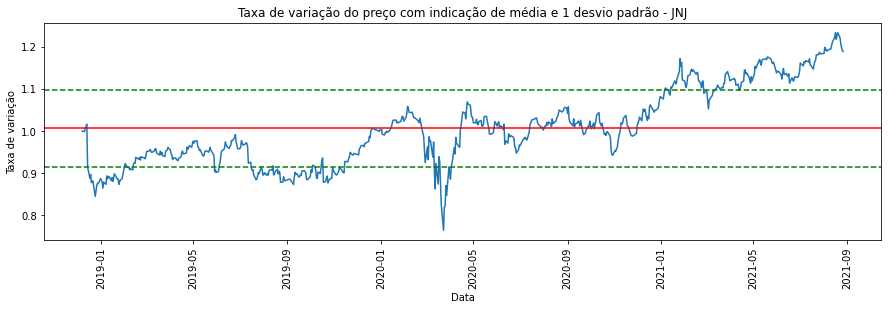

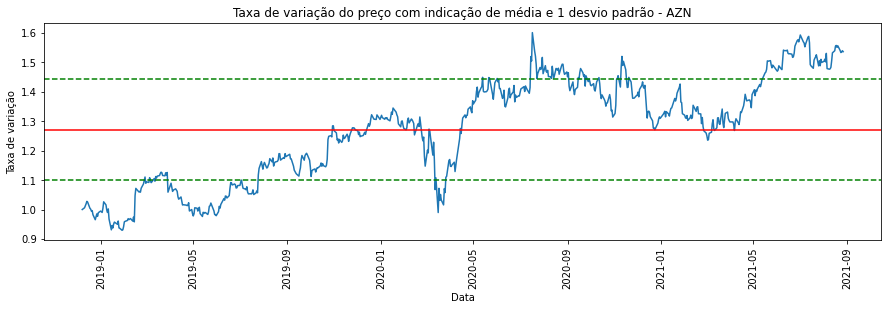

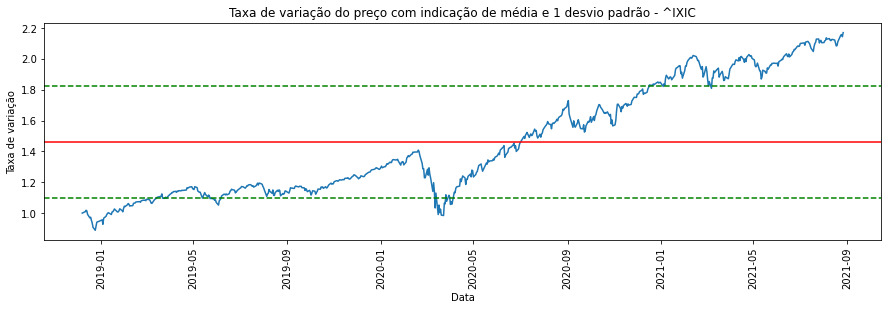

In [23]:
# Plotando gráficos com série história da taxa de variação geral dos ativos
for ativo in acoes:
    plt.figure(figsize=(15,4))
    plt.plot(acoes_df_variacao["Date"], acoes_df_variacao[ativo])
    plt.axhline(y = acoes_df_variacao[ativo].mean(), color='r', linestyle='-')
    plt.axhline(y = acoes_df_variacao[ativo].mean() + 1*acoes_df_variacao[ativo].std(), color='g', linestyle='--')
    plt.axhline(y = acoes_df_variacao[ativo].mean() - 1*acoes_df_variacao[ativo].std(), color='g', linestyle='--')
    plt.xticks(rotation=90)
    plt.xlabel('Data')
    plt.ylabel('Taxa de variação')
    plt.title('Taxa de variação do preço com indicação de média e 1 desvio padrão - %s' %ativo)
    plt.show()

Pode-se considerar que a amplitude entre a média e o desvio padrão traz informações sobre a variabilidade dos valores, enquanto que os valores acima do limite superior e abaixo do limite inferior do desvio padrão nos informam sobre o viés.

Caso a maior parte dos valores esteja dentro da amplitude entre a média e o desvio padrão, a variabilidade é baixa. O contrário também é verdade.

No caso do viés, caso a maior parte dos valores esteja fora dos limites (acima do superior e abaixo do inferior), o viés é alto. O contrário também é verdade.

### Exemplo - JNJ

Para o exemplo, iremos avaliar a série histórica dos preços do ativo JNJ. Da mesma forma que nos gráficos anteriores, temos o preço da ação com a indicação da média (linha vermelha) e o desvio padrão acima e abaixo da média (linha pontilhada verde superior e inferior). A linha azul, que mostra os valores dos preços individualmente, pode ser "condensada" na linha vermelha (média).

Cada um dos gráficos possui limites diferentes utilizando o desvio-padrão. No primeiro gráfico, os limites foram calculados considerando variação de um desvio padrão da média. No segundo, dois desvios padrão e no terceiro três.

Percebe-se que à medida em que aumentamos os limites superior e inferior, o viés diminui e a variabilidade aumenta. No primeiro gráfico temos uma variabilidade baixa e um viés alto. Ao analisarmos o terceiro gráfico, chegamos ao limite pois não temos nenhum viés, porém a variabilidade é muito grande.

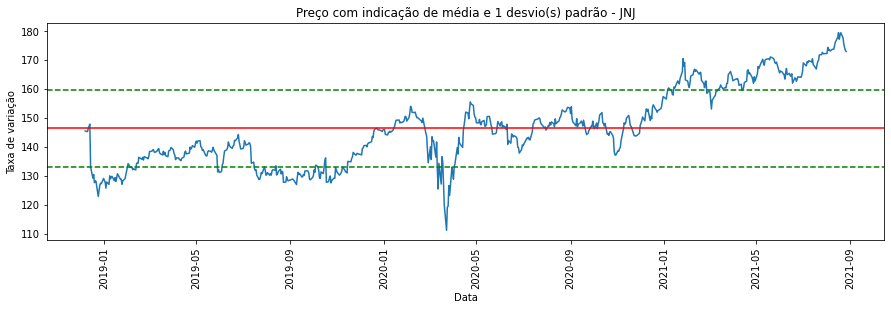

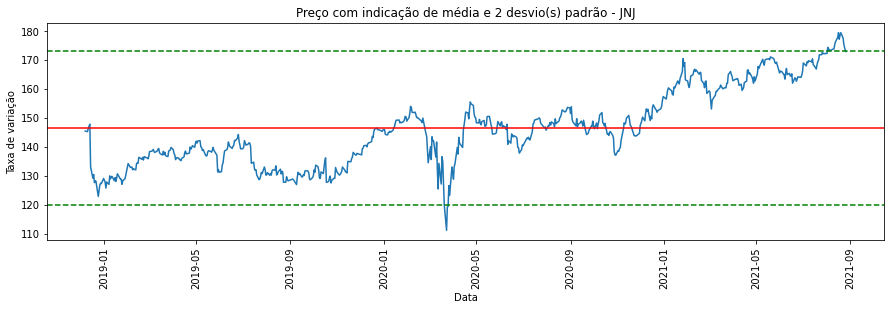

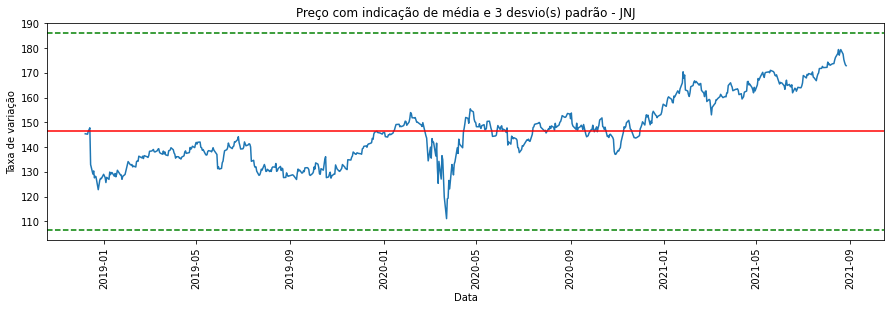

In [24]:
# Lista de quantidade de desvios padrão
qtd_dp = [1, 2, 3]

# Plotando gráficos com diferentes desvios padrão
for dp in qtd_dp:
    plt.figure(figsize=(15,4))
    plt.plot(acoes_df["Date"], acoes_df["JNJ"])
    plt.axhline(y = acoes_df["JNJ"].mean(), color='r', linestyle='-')
    plt.axhline(y = acoes_df["JNJ"].mean() + dp*acoes_df["JNJ"].std(), color='g', linestyle='--')
    plt.axhline(y = acoes_df["JNJ"].mean() - dp*acoes_df["JNJ"].std(), color='g', linestyle='--')
    plt.xticks(rotation=90)
    plt.xlabel('Data')
    plt.ylabel('Taxa de variação')
    plt.title('Preço com indicação de média e %s desvio(s) padrão - JNJ' %dp)
    plt.show()

## Taxa de retorno diário de cada ativo (Taxa de variação diária)

A taxa de retorno diário mede a valorização de um determinado investimento, representando o ganho ou perda a cada dia.

Calcula-se a taxa de retorno diário subtraindo o valor do dia do cálculo pelo valor do dia anterior e dividindo esse resultado novamente pelo valor do dia anterior. Caso se queira calcular o valor em percentual, multiplica-se por 100.

$$ \mathbb{E}(R) = \mathbb{E}\frac{P_t - P_{t-1}}{P_{t-1}} $$

In [25]:
# Cálculo da taxa de retorno diário de cada ativo
taxa_retorno_dia = (acoes_df_sdata / acoes_df_sdata.shift(1))-1
taxa_retorno_dia

PFE      MRNA       JNJ       AZN     ^IXIC
0         NaN       NaN       NaN       NaN       NaN
1    0.010929  0.010753 -0.001169  0.006024  0.007357
2   -0.008784 -0.042021  0.008536  0.006509  0.001611
3    0.003408  0.037202  0.004096  0.006467  0.009454
4    0.009284  0.004283  0.005031  0.008481 -0.003942
..        ...       ...       ...       ...       ...
681  0.024836  0.075487 -0.010198 -0.009934  0.015494
682 -0.031043 -0.041152 -0.012499 -0.004762  0.005163
683 -0.017983  0.007419 -0.006614  0.001025  0.001469
684 -0.002736  0.006108 -0.005338  0.003073 -0.006386
685 -0.016463 -0.045166 -0.002135 -0.002212  0.012290

[686 rows x 5 columns]

Agora vamos calcular a taxa de retorno média diária (em %) de cada ação.

### Média - Taxa de Retorno Diária

In [26]:
# Calculando a média da taxa de retorno diária (em percentual) dos ativos
taxa_retorno_media = taxa_retorno_dia.mean()*100
taxa_retorno_media

PFE      0.030674
MRNA     0.571734
JNJ      0.036116
AZN      0.078179
^IXIC    0.126404
dtype: float64

Esse valor é diferente do cálculo que fizemos anteriormente da taxa de retorno geral, em que usamos apenas o valor do primeiro registro e do último (mais atual), para, com a diferença, encontrar a variação. Nesse caso, utilizamos os valores de toda a série temporal para calcular a média da taxa de variação, nesse caso, diária.

### Desvio-padrão - Taxa de Retorno Diária

In [27]:
# Calculando o desvio-padrão da taxa de retorno diária (em percentual) dos ativos
taxa_retorno_dp = taxa_retorno_dia.std()*100
taxa_retorno_dp

PFE      1.694431
MRNA     5.151227
JNJ      1.469350
AZN      1.763517
^IXIC    1.618547
dtype: float64

Nesse caso o desvio-padrão é calculado com base nas taxas de retorno diárias, não considerando o valor de cada ativo.

### Gráficos com série histórica da taxa de variação diária do ativo JNJ

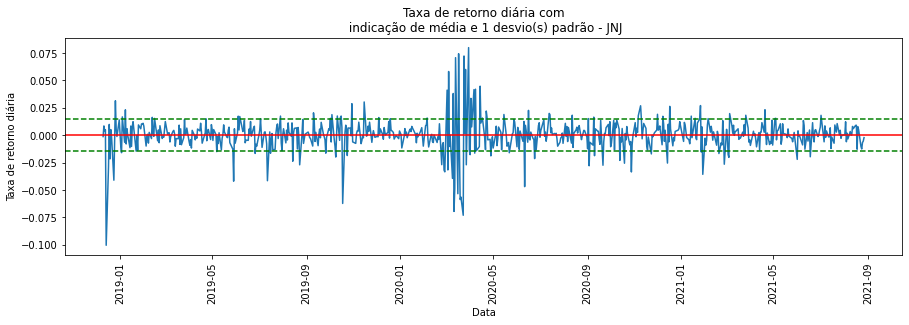

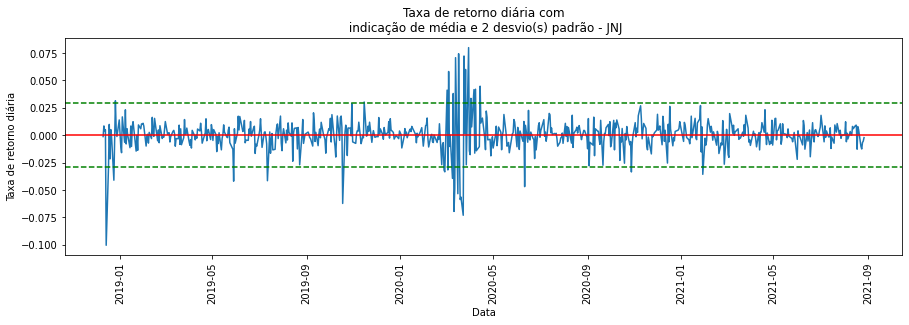

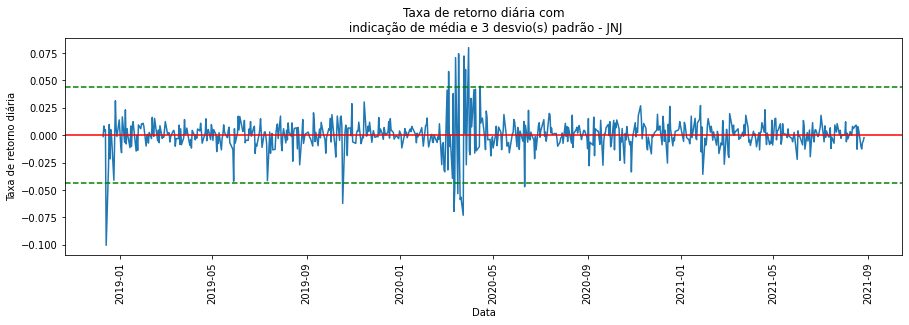

In [28]:
# Plotando gráficos com a variação das taxas de retorno diária, média e desvio-padrão da JNJ

for dp in qtd_dp:
    plt.figure(figsize=(15,4))
    plt.plot(acoes_df["Date"], taxa_retorno_dia["JNJ"])
    plt.axhline(y = taxa_retorno_dia["JNJ"].mean(), color='r', linestyle='-')
    plt.axhline(y = taxa_retorno_dia["JNJ"].mean() + dp*taxa_retorno_dia["JNJ"].std(), color='g', linestyle='--')
    plt.axhline(y = taxa_retorno_dia["JNJ"].mean() - dp*taxa_retorno_dia["JNJ"].std(), color='g', linestyle='--')
    plt.xticks(rotation=90)
    plt.xlabel('Data')
    plt.ylabel('Taxa de retorno diária')
    plt.title('Taxa de retorno diária com\n indicação de média e %s desvio(s) padrão - JNJ' %dp)
    plt.show()

A diferença desses gráficos (taxa de retorno diária) para os três gráficos do mesmo ativo que foi apresentado anteriormente (preço) é que, neste caso, a taxa de retorno gira muito próxima de zero. Nos gráficos temos a média desse valor (linha vermelha) e os desvios padrão acima e abaixo da média (linhas verdes pontilhadas).

Da mesma forma como foi avaliado utilizando-se os preços, nesse casos também é possível notar que o uso de um desvio-padrão resulta em um viés alto, mas com uma variabilidade baixa. À medida em que aumentamos os desvios padrão, diminuímos o viés, mas aumentamos a variabilidade.

## Gráfico com série histórica da taxa de variação diária de todos os ativos

In [29]:
# Concatenando coluna Date com o daframe de taxas de retorno diários
taxa_retorno_dia_date = pd.concat([acoes_df["Date"], taxa_retorno_dia], axis=1)
taxa_retorno_dia_date

Date       PFE      MRNA       JNJ       AZN     ^IXIC
0   2018-12-07       NaN       NaN       NaN       NaN       NaN
1   2018-12-10  0.010929  0.010753 -0.001169  0.006024  0.007357
2   2018-12-11 -0.008784 -0.042021  0.008536  0.006509  0.001611
3   2018-12-12  0.003408  0.037202  0.004096  0.006467  0.009454
4   2018-12-13  0.009284  0.004283  0.005031  0.008481 -0.003942
..         ...       ...       ...       ...       ...       ...
681 2021-08-23  0.024836  0.075487 -0.010198 -0.009934  0.015494
682 2021-08-24 -0.031043 -0.041152 -0.012499 -0.004762  0.005163
683 2021-08-25 -0.017983  0.007419 -0.006614  0.001025  0.001469
684 2021-08-26 -0.002736  0.006108 -0.005338  0.003073 -0.006386
685 2021-08-27 -0.016463 -0.045166 -0.002135 -0.002212  0.012290

[686 rows x 6 columns]

In [30]:
# Plotando gráfico com a taxa de variação de todas as ações
fig = px.line(title="Taxa de retorno diária de todos os ativos")
for i in taxa_retorno_dia_date.columns[1:]:
    fig.add_scatter(x=taxa_retorno_dia_date["Date"], y=taxa_retorno_dia_date[i], name=i)
fig.show()

## Análise conjunta de ativos

### Covariância entre os ativos

A covariância é uma medida para comparar dois grupos de dados a fim de entender como eles se relacionam entre si e mede a relação linear entre duas variáveis.

A covariância será positiva se as duas variáveis tendem a variar mesmo sentido, ou seja, valores de uma determinada variável, por exemplo X, acima da sua média estão associados a valores de outra variável, por exemplo Y, acima de sua média. O mesmo ocorre para valores de ambas variáveis inferiores à média.

A covariância será negativa se valores acima da média de uma variável estão associados a valores inferiores à média da outra.

Vamos calcular a covariância entre as taxas de retorno dos ativos.

In [31]:
# Descobrindo a covariância entre os ativos
covariancia = taxa_retorno_dia.cov()
covariancia

PFE      MRNA       JNJ       AZN     ^IXIC
PFE    0.000287  0.000157  0.000147  0.000129  0.000135
MRNA   0.000157  0.002654  0.000084  0.000080  0.000094
JNJ    0.000147  0.000084  0.000216  0.000120  0.000136
AZN    0.000129  0.000080  0.000120  0.000311  0.000140
^IXIC  0.000135  0.000094  0.000136  0.000140  0.000262

Podemos calcular, também, a correlação entre os ativos.

### Correlação entre os ativos

A correlação é semelhante à covariância. A diferença é que os coeficientes de correlação são padronizados, ou seja, um relacionamento linear perfeito tem como resultado um coeficiente de correlação 1.

A correlação mede tanto a força como a direção da relação linear entre duas variáveis. Já no cálculo da covariância, os valores não são padronizados. Portanto, a covariância pode variar de menos infinito a mais infinito e o valor para uma relação linear ideal depende dos dados.

Assim, a correlação é uma métrica mais fácil para se realizar uma análise exploratória de dados.

In [32]:
# Descobrindo a correlação entre os ativos
correlacao = taxa_retorno_dia.corr()
correlacao

PFE      MRNA       JNJ       AZN     ^IXIC
PFE    1.000000  0.180432  0.592197  0.430402  0.490580
MRNA   0.180432  1.000000  0.110779  0.088128  0.112209
JNJ    0.592197  0.110779  1.000000  0.461647  0.570450
AZN    0.430402  0.088128  0.461647  1.000000  0.489106
^IXIC  0.490580  0.112209  0.570450  0.489106  1.000000

Vamos construir um mapa de calor mostrando a correlação entre os ativos para visualizar melhor a relação linear entre os ativos.

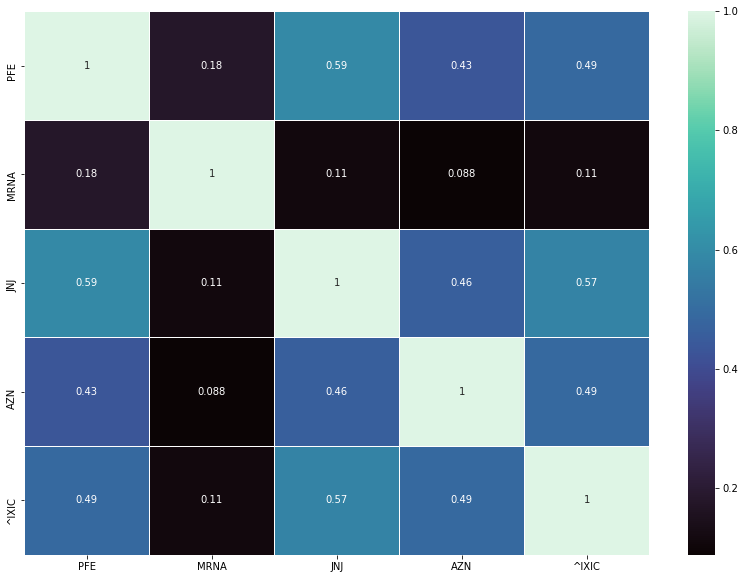

In [33]:
# Construindo mapa de calor com a correlação entre os ativos
plt.figure(figsize=(14,10))
sns.heatmap(taxa_retorno_dia.corr(), annot=True, linewidths=.5, cmap="mako");

Na linha diagonal que corta o gráfico temos a relação linear perfeita (1), tendo em vista os valores desse linha correspondem à correlação entre os mesmos ativos.

Desconsiderando esses valores, que claramente não trazem informação útil, verifica-se que os espaços mais claros correspondem às correlações mais fortes enquanto os mais escuros às correlações mais fracas.

Assim, entre o ativo PFE e o JNJ verifica-se uma correlação positiva de 0.59, o que corresponde à uma correlação moderada. Isso significa, na prática, que existe um um aumento no valor do ativo JNJ quando o ativo PFE também aumenta. O contrário também é verdade, sendo possível analisar os dados do gráfico partindo das colunas ou das linhas. Ou seja, existe uma relação moderada na variabilidade entre os ativos.

De outro modo, a correlação entre os ativos AZN e MRNA é de 0.088, que pode-se considerar fraca ou até mesmo nula de acordo com alguns autores. Essa correlação implica dizer que não verifica-se de forma relevante que a variabilidade do ativo AZN está relacionado à variabilidade do MRNA e vice-versa.

Destaca-se que a correlação não implica causalidade, ou seja, ela indica a força e a direção da relação linear entre duas variáveis, mas não explica o motivo de essa força e direção existirem. Não existe uma relação de causa e consequência entre os ativos.

## Construindo uma carteira de ações com pesos específicos

In [34]:
# Lista de ativos na carteira
carteira = taxa_retorno_dia.columns
carteira

Index(['PFE', 'MRNA', 'JNJ', 'AZN', '^IXIC'], dtype='object')

In [2]:
# Criando pesos para os ativos na carteira, mantendo peso 0 para o índicador financeiro ^IXIC
pesos_carteira = np.random.random(len(carteira)-1)
np.random.seed(4)
pesos_carteira /= np.sum(pesos_carteira)
pesos_carteira = np.append(pesos_carteira, [0])
print("Peso dos ativos da carteira", pesos_carteira)

NameError: name 'np' is not defined

In [36]:
# Checando a soma do peso dos ativos da carteira, que deve ser igual a 1 ou muito próximo
pesos_carteira.sum()

1.0

### Cálculo do Retorno, da Variância e da Volatilidade/Risco da Carteira (Desvio Padrão)

#### Taxa de Retorno Média

In [37]:
# Calculando a taxa de retorno da carteira, considerando os pesos e a média das taxas de retorno diárias
retorno_car = np.dot(pesos_carteira, taxa_retorno_dia.mean()*252).round(2)
retorno_car

0.6

Ou seja, a taxa de retorno média da carteira, considerando os pesos estabelecidos anteriormente, é de aproximadamente 16%. 

#### Variância

In [38]:
# Calculando a variância da carteira, considerando os pesos e a média das taxas de retorno diárias
var_car = np.dot(pesos_carteira, np.dot(taxa_retorno_dia.cov() *252, pesos_carteira)).round(2)
var_car

0.13

A variância da carteira é de aproximadamente 0.05.

#### Volatilidade/Risco (Desvio Padrão)

In [39]:
# Calculando a volatilidade/risco (dp) da carteira, considerando os pesos e a média das taxas de retorno diárias
vol_car = math.sqrt(var_car)
round(vol_car, 2)

0.36

A volatilidade da carteira (risco), calculada pelo desvio padrão, corresponde à aproximadamente 22%. Ou seja, a minha carteira pode variar para  mais ou para menos em 22%.

### Cálculo do Retorno, da Variância e da Volatilidade/Risco da Carteira (Desvio Padrão) considerando o índice ^IXIC

#### Taxa de Retorno Média

In [40]:
# Definindo valor máximo para o ativo ^IXIC
pesos_id = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

In [41]:
#### Calculando a taxa de retorno considerando o peso do índice e a média das taxas de retorno diárias
retorno_id = np.dot(pesos_id, taxa_retorno_dia.mean()*252).round(2)
retorno_id

0.32

Ou seja, a taxa de retorno média do ativo ^IXIC é de aproximadamente 32%. 

#### Variância

In [42]:
# Calculando a variância considerando o peso do íncice e a média das taxas de retorno diárias
var_id = np.dot(pesos_id, np.dot(taxa_retorno_dia.cov() *252, pesos_id)).round(2)
var_id

0.07

A variância da carteira é de aproximadamente 0.7.

#### Volatilidade/Risco (Desvio Padrão)

In [43]:
# Calculando a volatilidade/risco (dp) da carteira, considerando os pesos e a média das taxas de retorno diárias
vol_id = round(math.sqrt(var_id), 2)
vol_id

0.26

A volatilidade do ativo ^IXIC, calculada pelo desvio padrão, corresponde à aproximadamente 26%.

### Comparando a carteira com o índice (indicador ^IXIC)

In [44]:
# Atribuindo dados ao DataFrame
dados_car_id = {'Retorno':[retorno_car, retorno_id], 'Variância':[var_car, var_id], 'Volatilidade':[vol_car, vol_id]}  
  
# Criando DataFrame
df_car_id = pd.DataFrame(dados_car_id, index =['Carteira', '^IXIC'])  
  
# Mostrando DataFrame
print(df_car_id)    

          Retorno  Variância  Volatilidade
Carteira     0.60       0.13      0.360555
^IXIC        0.32       0.07      0.260000


Percebe-se que o retorno considerando apenas o índice único do ativo ^IXIC (0.32) é maior do que o retorno da carteira (0.16). Porém, o risco do ativo ^IXIC (0.26) é maior do que o risco utilizando-se os pesos atribuídos à carteira (0.22).

Não há decisão uma decisão mais efetiva. O que busca-se é conhecer o comportamento dos ativos, calculando-se as métricas, para apoiar a tomada de decisão do investidor, que pode ter maior ou menor apetite ao risco, por exemplo.

## Simulação de opções de carteiras em busca da mais eficiente

Para realizar a simulação de diversas opções de carteiras, precisamos calcular o retorno, a volatilidade e o índice sharpe dos ativos da carteira.

O **índice sharpe** avalia a rentabilidade de um investimento em relação ao risco da aplicação financeira. 

In [45]:
# Lista de ativos na carteira
carteira_portfolio = list(taxa_retorno_dia.columns[0:4])

# Criando listas que irão receber as informações
retorno_port = []
vol_port = []
sharpe_port = []

pesos_carteira_port = []
lista_pesos_port = []

qtd_ativos_cart = len(carteira_portfolio)

In [46]:
print(carteira_portfolio)
print(qtd_ativos_cart)

['PFE', 'MRNA', 'JNJ', 'AZN']
4


In [47]:
# Criando objeto apenas com a taxas médias de retorno dos ativos, excluindo o indicador
taxa_retorno_media_port = taxa_retorno_media.drop(labels="^IXIC")
taxa_retorno_media_port

PFE     0.030674
MRNA    0.571734
JNJ     0.036116
AZN     0.078179
dtype: float64

In [48]:
# Criando dataframe apenas com a covariância das 4 ações, excluindo o indicador
covariancia_port = covariancia
covariancia_port = covariancia_port.drop(labels="^IXIC")
covariancia_port = covariancia_port.drop(labels="^IXIC", axis=1)
covariancia_port

PFE      MRNA       JNJ       AZN
PFE   0.000287  0.000157  0.000147  0.000129
MRNA  0.000157  0.002654  0.000084  0.000080
JNJ   0.000147  0.000084  0.000216  0.000120
AZN   0.000129  0.000080  0.000120  0.000311

### Definindo simulações e realizando cálculos

In [49]:
# Definindo quantidade de simulações
qtd_simul_port = 6000
np.random.seed(9)

In [50]:
# Gerando arrays com pesos simulados para os ativos da carteira
for i in range(qtd_simul_port):
    pesos_carteira_port = np.random.random(qtd_ativos_cart)
    pesos_carteira_port /= np.sum(pesos_carteira_port)
    lista_pesos_port.append(pesos_carteira_port)
    
    # Calculando o retorno esperado e criando um array com os retornos das simulações
    retorno_esp = np.dot(pesos_carteira_port, taxa_retorno_media_port)
    retorno_port.append(retorno_esp)
    
    # Calculando a variância e criando um array com as volatilidades das simulações 
    variancia = np.dot(pesos_carteira_port.T , np.dot(covariancia_port, pesos_carteira_port))
    volatilidade = np.sqrt(variancia)
    vol_port.append(volatilidade)
    
    # Calculando o índice sharpe e criando um array com os valores das simulações
    sharpe_ratio = retorno_esp / volatilidade
    sharpe_port.append(sharpe_ratio)

## Fronteira Eficiente de Markowitz

In [51]:
# Crianco um dicionário das carteiras com o Retorno, a Volatilidade e o Índice Sharpe
dic_carteiras = ({'Retornos': retorno_port, 'Volatilidade': vol_port, 'Sharpe': sharpe_port})

In [52]:
# Criando Dataframe com informações de Retorno, Volatilidade e Índice Sharp, com pesos ação, de cada simulação

for i, acao in enumerate(carteira_portfolio):
    dic_carteiras[acao + ' Peso'] = [pesos_carteira_port[i] for pesos_carteira_port in lista_pesos_port]
    
    portfolio = pd.DataFrame(dic_carteiras)
    
    colunas = ['Retornos', 'Volatilidade', 'Sharpe'] + [acao + ' Peso' for acao in carteira_portfolio]
    
portfolio = portfolio[colunas]

portfolio.head()

Retornos  Volatilidade     Sharpe  PFE Peso  MRNA Peso  JNJ Peso  AZN Peso
0  0.276415      0.024753  11.166720  0.009085   0.439527  0.434184  0.117204
1  0.159477      0.016136   9.883451  0.138337   0.212755  0.407395  0.241513
2  0.186332      0.017816  10.458961  0.056994   0.234253  0.113077  0.595676
3  0.053657      0.013432   3.994679  0.420487   0.017133  0.309123  0.253257
4  0.171760      0.017235   9.965589  0.318988   0.236895  0.194602  0.249515

### Identificando o maior valor de Índice Sharpe

In [53]:
sharpe_max = portfolio["Sharpe"].max()
cart_sharp_max = portfolio.loc[portfolio["Sharpe"] == sharpe_max]
cart_sharp_max.T

5713
Retornos       0.317494
Volatilidade   0.027347
Sharpe        11.609909
PFE Peso       0.013218
MRNA Peso      0.486321
JNJ Peso       0.001991
AZN Peso       0.498470

In [54]:
# Gravando a taxa de retorno e a volatilidade da carteira com maior sharpe identificado
retorno_sharpe_max = cart_sharp_max['Retornos']
volatilidade_sharpe_max = cart_sharp_max['Volatilidade']

### Identificando o menor valor de Volatilidade

In [55]:
vol_min = portfolio["Volatilidade"].min()
cart_vol_min = portfolio.loc[portfolio["Volatilidade"] == vol_min]
cart_vol_min.T

4380
Retornos      0.061800
Volatilidade  0.013112
Sharpe        4.713083
PFE Peso      0.208795
MRNA Peso     0.030026
JNJ Peso      0.505892
AZN Peso      0.255287

In [56]:
# Gravando a taxa de retorno e a volatilidade da carteira com a menor volatilidade
retorno_vol_min = cart_vol_min['Retornos']
volatilidade_vol_min = cart_vol_min['Volatilidade']

### Plotando o Gráfico

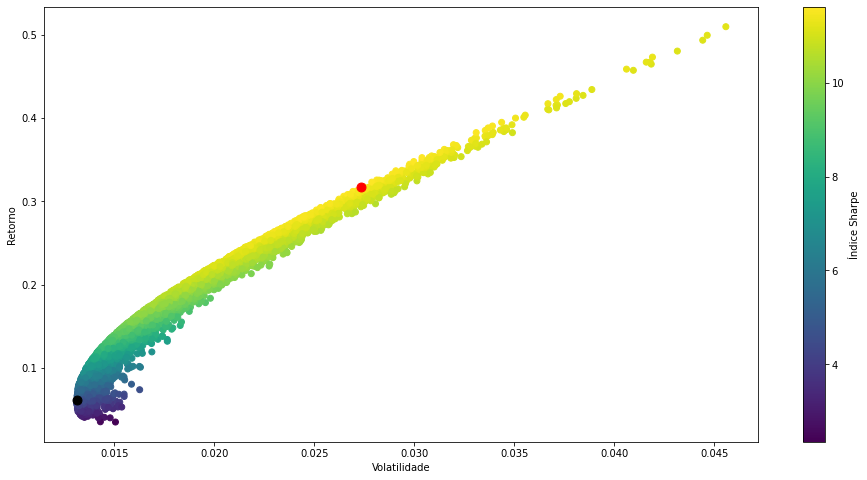

In [57]:
plt.figure(figsize=(16,8))
plt.scatter(vol_port, retorno_port, c=sharpe_port, cmap='viridis')
plt.colorbar(label='Índice Sharpe')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(volatilidade_sharpe_max, retorno_sharpe_max, c='red', s=80) # ponto vermelho
plt.scatter(volatilidade_vol_min, retorno_vol_min, c='black', s=80) # ponto preto
plt.show()

O investimento no ponto vermelho representa o ponto de maior rentabilidade. Porém, corresponte a um risco mais elevado. Já o ponto preto mostra o investimento com menos risco (volatilidade).

Vamos descobrir a fronteira eficiente das carteiras, que representa a linha de pontos em que há uma maximização do portfólio.

### Fronteira eficiente das carteiras

In [58]:
# Definindo função para trazer o retorno, volatilidade e índice sharpe de qualquer array de pesos
def get_ret_vol_sharpe(pesos_carteira_port):
    pesos_carteira_port = np.array(pesos_carteira_port)
    ret_line = np.dot(pesos_carteira_port, taxa_retorno_media_port)
    vol_line = np.sqrt(np.dot(pesos_carteira_port.T , np.dot(covariancia_port, pesos_carteira_port)))
    sharpe_line = ret_line/vol_line
    return np.array([ret_line, vol_line, sharpe_line])

# Definindo função para trazer proporção de sharpe negativo de alguns pesos
def neg_sharpe(pesos_carteira_port):
    return get_ret_vol_sharpe(pesos_carteira_port)[2] * -1

# Definindo função para verificar a soma dos pesos
def check_sum(pesos_carteira_port):
    return np.sum(pesos_carteira_port)-1

In [59]:
# Criando variavel pare receber informações, estimativa inicial e limites específicos para ajudar a minimização
cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

In [60]:
# Criando a função de minimização
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -11.628320176482859
     jac: array([ 9.69900489e-01,  5.73396683e-05,  1.77428961e-01, -6.10351562e-05])
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.61058233e-16, 5.14821279e-01, 0.00000000e+00, 4.85178721e-01])


In [61]:
# Obtendo o retorno, volatilidade e sharpe em que o índice sharpe é o máximo
get_ret_vol_sharpe(opt_results.x)

array([ 0.33227149,  0.02857433, 11.62832018])

In [62]:
# Definindo variável para limite do eixo y
frontier_y = np.linspace(0,0.6,200)

Definimos o limite de y do retorno em 0.6, pois o valor máximo está por volta apenas um pouco acima de 0.5, conforme gráfico anterior.

In [63]:
# Definindo função para auxiliar a minimizar a volatilidade
def minimize_volatility(pesos_carteira_port):
    return get_ret_vol_sharpe(pesos_carteira_port)[1]

In [64]:
# Obtendo os valores de x para a fronteira eficiente
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sharpe(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

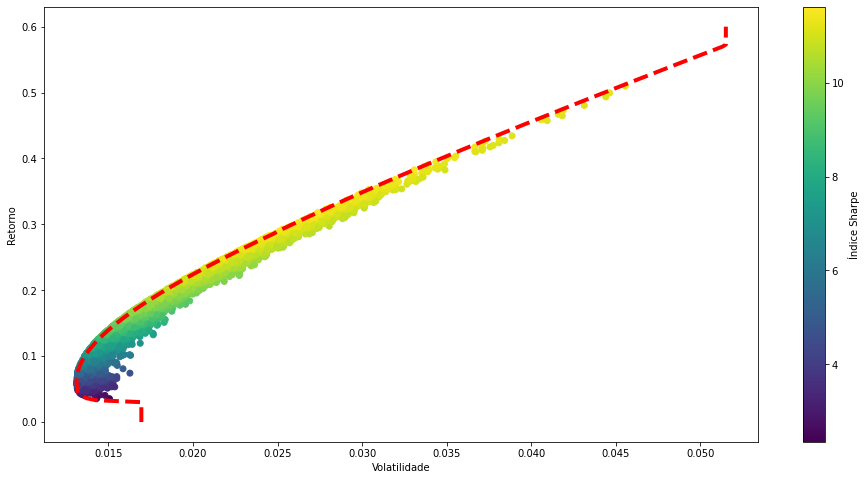

In [65]:
# Plotando o gráfico com a curva de fronteira eficiente
plt.figure(figsize=(16,8))
plt.scatter(vol_port, retorno_port, c=sharpe_port, cmap='viridis')
plt.colorbar(label='Índice Sharpe')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=4)
plt.savefig('grafico-fronteira-eficiente.png')
plt.show()

A fronteira eficiente é o conjunto de carteiras que nos traz o maior retorno esperado para um determinado nível de risco. Ou, de outra perspectiva, o risco mínimo para um retorno esperado.

Dessa forma, todos os indivídos que criam um portfólio na fronteira, estão maximizado seus resultados. Eles estao em equilívrio no mercado de ações. Assim, recomenda-se que seja montada uma carteira que esteja nessa fronteira.

Dado um nivel de aversão de risco, quanto mais pra cima da fronteira, mais o indivíduo aceita risco. Quanto mais para baixo (em direção à extremidade esquerda) mais ele é avesso ao risco.